In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage,ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

c:\Users\User\Desktop\Working_with_LLMS\llmvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful


In [2]:
# Load environment variables
load_dotenv()
openai_api_key = os.getenv("openai_key")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded successfully")

✅ API key loaded successfully


In [ ]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")


✅ LLM initialized: gpt-4o-mini


state is the data that flows through our graph ..so it has something to do with conversation. 

Nodes are functions that process state and return updates

In [4]:
#system prompt that defines assistant behavior 

sys_msg= SystemMessage(
    content="You are a friendly assistant but answers user question.Be careful and concise."
)
def assistant(state:MessagesState)-> dict:
    """
    The assistant node - processes messages and generates response.
    """

    # combine system prompt with conversation history
    messages=[sys_msg] + state["messages"]

    # Get response from LLM
    response=llm.invoke(messages)

    # Return as state update
    return {"messages": [AIMessage(content=response.content)]}

print("✅ Assistant node defined")


✅ Assistant node defined


## Creating a stategraph

In [5]:
# create a stategraph with messagesState

builder= StateGraph(MessagesState)

#Add the assistant mode
builder.add_node("assistant",assistant)

#define the flow 
# START → assistant → END
builder.add_edge(START,"assistant")
builder.add_edge("assistant",END)

## checkpointers(memory)

In [6]:
#create a memory checkpointer (stores in memory)
memory=MemorySaver()

#compile the graph with memory
agent=builder.compile(checkpointer=memory)

### visualizing the graph 

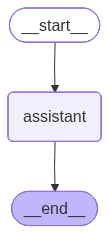

In [7]:
try:
    display(Image(agent.get_graph().draw_mermaid_png()))

except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → END")

## running the Agent 
### Session IDs (Thread IDs)

Each conversation has a unique **thread_id**. Messages with the same thread_id share memory.

In [8]:
#define a session ID for this conversation#
session_id="chat_session_001"
print(f"Starting conversation with session ID: {session_id}")

Starting conversation with session ID: chat_session_001


In [ ]:
def run_conversation(user_input: str,thread_id: str =session_id):
    """
    Send a message to the agent and get response.
    ⚠️ WARNING: Using default thread_id shares conversation acrosss all calls!
    In production, ALWAYS provide unique thread_id per user.
    """

    #invoke the agent
    result= agent.invoke({"messages": [HumanMessage(content=user_input)]},config={"configurable":{"thread_id":thread_id}})

    #print the conversation history
     # Print the conversation
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n👤 User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 Agent: {message.content}")
    
    print("\n" + "="*70)

print("✅ Conversation function ready")

✅ Conversation function ready


In [10]:
run_conversation("Hello! What's your name?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?



In [11]:
# Follow-up question - does it remember?
run_conversation("What's my favorite color?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is. If you'd like to share it with me, I'd love to know!



In [12]:
run_conversation("my favorite color is red")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is. If you'd like to share it with me, I'd love to know!

👤 User: my favorite color is red
🤖 Agent: Great choice! Red is a vibrant and powerful color. Do you have a favorite shade of red, or do you just love it all?



In [13]:
run_conversation("your name shoud be HAmidco AI Assistant")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is. If you'd like to share it with me, I'd love to know!

👤 User: my favorite color is red
🤖 Agent: Great choice! Red is a vibrant and powerful color. Do you have a favorite shade of red, or do you just love it all?

👤 User: your name shoud be HAmidco AI Assistant
🤖 Agent: That's a creative name! You can call me Hamidco AI Assistant if you’d like. How can I assist you today?



In [14]:
run_conversation("Hello! What's your name?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is. If you'd like to share it with me, I'd love to know!

👤 User: my favorite color is red
🤖 Agent: Great choice! Red is a vibrant and powerful color. Do you have a favorite shade of red, or do you just love it all?

👤 User: your name shoud be HAmidco AI Assistant
🤖 Agent: That's a creative name! You can call me Hamidco AI Assistant if you’d like. How can I assist you today?

👤 User: Hello! What's your name?
🤖 Agent: Hello! You can call me Hamidco AI Assistant. How can I help you today?



In [15]:
# Follow-up question - does it remember?
run_conversation("What's my favorite color?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I don't have a specific name, but you can call me Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is. If you'd like to share it with me, I'd love to know!

👤 User: my favorite color is red
🤖 Agent: Great choice! Red is a vibrant and powerful color. Do you have a favorite shade of red, or do you just love it all?

👤 User: your name shoud be HAmidco AI Assistant
🤖 Agent: That's a creative name! You can call me Hamidco AI Assistant if you’d like. How can I assist you today?

👤 User: Hello! What's your name?
🤖 Agent: Hello! You can call me Hamidco AI Assistant. How can I help you today?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is red! Would you like to talk more about it?



to build an agent you need to for innitialize or define the nodes that would be needed,the tools and then compile (i.e wrap with a memorystate)

In [16]:
# initializing llm

llm=ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"LLM Initialized: {llm.model_name}")



LLM Initialized: gpt-4o-mini


## Creating tools

In [17]:
@tool
def calculator(expression:str)-> str:
    """
    Evaluate a mathematical expression and return the result.Use this toool when you need to perform calculations.

    Args:
        expression: A mathematical expression like "2 + 2" or "15*37"01_Introduction_to_LangGraph.ipynb

    Returns:
        The calculated result as a string

    Examples:
    - "2 + 2" returns "4"
    - "100 / 5" returns "20.0"
    - "2 ** 10" returns "1024"

    """
    try:
        #Evaluate the expression safely
        result=eval(expression,{"__builtins__": {}},{})
        return str(result)
    
    except Exception as e:
        return f"Error calculating: {str(e)}"
    
print("Calculator tool created")

Calculator tool created


In [18]:
# Test the calculator tool
result = calculator.invoke({"expression": "2 + 2"})
print(f"123 * 456 = {result}")

result2 = calculator.invoke("2 ** 10")
print(f"2^10 = {result2}")

123 * 456 = 4
2^10 = 1024


In [19]:
@tool
def text_analyzer(text: str) -> str:
    """
    Analyze text and return statistics about it.
    Use this tool when you need to analyze or count things in text.
    
    Args:
        text: The text to analyze
        
    Returns:
        Statistics about the text (characters, words, sentences)
        
    Examples:
        - "Hello world" returns character count, word count, etc.
    """
    char_count = len(text)
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    
    return f"""Text Analysis:
- Characters: {char_count}
- Words: {word_count}
- Sentences: {sentence_count}
- First 50 chars: {text[:50]}..."""

print("✅ Text analyzer tool created")

✅ Text analyzer tool created


In [20]:
# Test the text analyzer
test_text = "Hello! This is a test. How are you today?"
result = text_analyzer.invoke({"text": test_text})
print(result)

Text Analysis:
- Characters: 41
- Words: 9
- Sentences: 3
- First 50 chars: Hello! This is a test. How are you today?...


In [21]:
# create a list of tools
tools = [calculator, text_analyzer]

llm_with_tools = llm.bind_tools(tools)

In [22]:
# Test: Does LLM decide to call calculator?
response = llm_with_tools.invoke([HumanMessage(content="What is 234 * 567?")])

print(f"Response type: {type(response)}")
print(f"\nContent: {response.content}")
print(f"\nTool calls: {response.tool_calls}")
response

Response type: <class 'langchain_core.messages.ai.AIMessage'>

Content: 

Tool calls: [{'name': 'calculator', 'args': {'expression': '234 * 567'}, 'id': 'call_NAJSLVeqRC6m9Lt2rHZ7VFkW', 'type': 'tool_call'}]


AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 219, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bbc38b4db', 'id': 'chatcmpl-Crt7DKUwdtq6lPrlEbqHzvjt0fYU9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b66fb-0884-7cc3-b036-740603656988-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '234 * 567'}, 'id': 'call_NAJSLVeqRC6m9Lt2rHZ7VFkW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 17, 'total_tokens': 236, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [23]:
# Test: Does LLM decide NOT to call tools for simple queries?
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you?")])

print(f"Content: {response2.content}")
print(f"Tool calls: {response2.tool_calls}")

Content: Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
Tool calls: []


## Define the Assistant Node

In [ ]:
sys_msg=SystemMessage(content="""You are a helpful asssitant with access to tools for specific funtions.
                      when asked to perform calculation you should use the calculator tool.
                      when asked to analyze text, use the text_analyzer tool.
                      if the function you are asked to perform is relating to health or medicine kindly tell them to visit the nearest clinic.
                      Do not use curse words or suicidal word that can cause emotional damage to users.
                      
                      only use tools when necessary and for simple questions answer directly.""")

def assistant(state:MessagesState)-> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """

    messages=[sys_msg] + state["messages"]
    response=llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("✅ Assistant node defined")

✅ Assistant node defined


### Define  Conditional Routing

This is the **key to agentic behavior** - the graph decides where to go based on whether tools were called!

In [25]:
def should_continue(state:MessagesState)-> Literal["tools","__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """

    last_message= state["messages"][-1]

    #check if llm made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool calls - we are done 
    return "__end__"


print("✅ Conditional routing function defined")

✅ Conditional routing function defined


In [26]:
# Create the graph 
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))  #ToolNode executes tool calls automatically

#Define edges
builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",should_continue,{"tools":"tools","__end__":END})

builder.add_edge("tools","assistant") # after tools, go back to asssistant

#Add memory checkpointer
memory=MemorySaver()
agent=builder.compile(checkpointer=memory)

print("✅ Agent graph compiled with tools and memory")

✅ Agent graph compiled with tools and memory


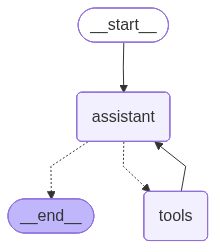

In [27]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
def run_agent(user_input: str,thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")


    result = agent.invoke(
        {"messages":[HumanMessage(content=user_input)]},
        config={"configurable":{"thread_id":thread_id}}
    )

    for message in result["messages"]:
        if isinstance(message,HumanMessage):
            continue
        elif isinstance(message,AIMessage):
            if message.tool_calls:
                print(f"🤖 Agent: [Calling tool: {message.tool_calls[0]['name']}]")
            else:
                print(f"🤖 Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"🔧 Tool Result: {message.content}")
    
    print(f"\n{'='*70}\n")
 
print("✅ Test function ready")

✅ Test function ready


In [29]:
run_agent("What is 12345 * 67890?")


👤 User: What is 12345 * 67890?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of 12345 * 67890 is 838102050.




In [30]:
run_agent("Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'")


👤 User: Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of 12345 * 67890 is 838102050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters:** 68
- **Words:** 10
- **Sentences:** 2
- **First 50 characters:** RAG systems combine retrieval with generation. The...




In [31]:
run_agent("Hello! What can you help me with?")


👤 User: Hello! What can you help me with?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of 12345 * 67890 is 838102050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters:** 68
- **Words:** 10
- **Sentences:** 2
- **First 50 characters:** RAG systems combine retrieval with generation. The...
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. Performing calculations.
2. Analyzing text for statistics like word count, character count, and more.
3. Providing general information and answering questions.

If you have a specific request or question, feel free to ask!




In [32]:
run_agent("How many words are in this sentence: 'LangGraph makes building agents easy'?")


👤 User: How many words are in this sentence: 'LangGraph makes building agents easy'?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of 12345 * 67890 is 838102050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters:** 68
- **Words:** 10
- **Sentences:** 2
- **First 50 characters:** RAG systems combine retrieval with generation. The...
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. Performing calculations.
2. Analyzing text for statistics like word count, character count, and more.
3. Providing general information and answering questions.

If you have a specific request or question, feel free to ask!
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 36
- Words: 5
- Sentences: 0
- First 50 chars: LangGraph makes building...
🤖 Agent:

In [33]:
# First query
run_agent("Calculate 100 * 50", thread_id="calc_session")


👤 User: Calculate 100 * 50

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of 100 * 50 is 5000.




In [34]:
run_agent("How many words are in this sentence: 'LangGraph makes building agents easy'?",thread_id="calc_session")


👤 User: How many words are in this sentence: 'LangGraph makes building agents easy'?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of 100 * 50 is 5000.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 36
- Words: 5
- Sentences: 0
- First 50 chars: LangGraph makes building...
🤖 Agent: The sentence "LangGraph makes building agents easy" contains 5 words.




In [35]:
# Get full message history
result = agent.invoke(
    {"messages": [HumanMessage(content="What is 15 * 25?")]},
    config={"configurable": {"thread_id": "inspect_session"}}
)

print("\n📋 FULL MESSAGE HISTORY:\n")
for i, msg in enumerate(result["messages"], 1):
    print(f"{i}. {type(msg).__name__}")
    if isinstance(msg, AIMessage) and msg.tool_calls:
        print(f"   Tool Call: {msg.tool_calls[0]['name']}({msg.tool_calls[0]['args']})")
    elif isinstance(msg, ToolMessage):
        print(f"   Content: {msg.content}")
    elif hasattr(msg, 'content'):
        print(f"   Content: {msg.content}")
    print()


📋 FULL MESSAGE HISTORY:

1. HumanMessage
   Content: What is 15 * 25?

2. AIMessage
   Tool Call: calculator({'expression': '15 * 25'})

3. ToolMessage
   Content: 375

4. AIMessage
   Content: 15 * 25 equals 375.



In [2]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

✅ All imports successful
